Here we test how closely PyTorchDIA can recover the exact solution when known transformations have been applied to an image. Using Section 3.1 of Bramich 2008 as a guide, we explore the following:

(i) The data image is created by shifting the reference image by one pixel in each of the positive x and y spatial directions, without resampling. The corresponding kernel should be the identity kernel (central pixel value of 1 and 0 elsewhere) shifted by one pixel in each of the negative u and v kernel  coordinates.

(ii) The data image  has been  created by convolving the reference image with a gaussian of $\sigma_K$ = 1.5.

(iii) We shifted the reference image by half a pixel in each of the positive x and y spatial directions to create the data image, an operation that required the resampling of the reference image. We used a cubic spline resampling method (scipy.ndimage.interpolation.shift)

However, we'll start with a test '0', where no transformation has been applied; we simply difference an image against itself. This is the only test for which we are truly testing the limiting numerical precision of our algorithm. Even if we shift an image by just a single integer pixel, there is now no longer a one-to-one mapping for pixels at the borders perpendicular to the axis along which the shift was applied.

In [1]:
# imports
import numpy as np
# scipy.ndimage.interpolation.shift # for consistency with pyDANDIA!
from scipy.ndimage.interpolation import shift
# quote for manuscript - e.g. 'we are doing bicubic spline interpolation'
from scipy.signal import convolve2d
from astropy.io import fits
from MakeFakeImage import MakeFake
import time
import matplotlib.pyplot as plt
%matplotlib inline

In the cell below we'll generate a synthetic reference image. This uses the image generation procedure outlined in Section 3.1 of the manuscript, albeit for a single image. Note however that the particular pyDANDIA implementation of this algorithm which we use in this work makes use of zero-padding so as to include all target image pixels into the kernel solution. This is at the expense of having a mathematically correct model image for the these boundary pixel, and so to mitigate this systematic, we will generate a large 1000x1000 pixel image. Further, due to reasons motivating test '0' above, the larger image will mitigate the effects due to lost inforamtion at the borders.



Max flux: 811511.4234160295
Frac for 142x142 image: 0.17628387964244158
Reference properties
Reference size: 1000
Number of sources: 1329
PSF standard deviation: 2.4014286128198323
Sky level: 734.6740023932911
F_max/F_total: 0.17628387964244158


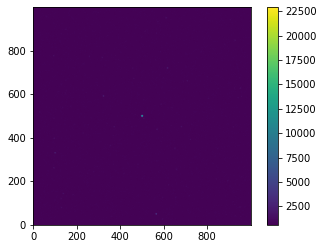

In [2]:
### generate a reference image
np.random.seed(42) # seed for reproducibility

size = 1000
log_density = np.random.uniform(0, 3, 1)[0]
#print(log_density)
star_density = 10**log_density # stars per 100x100 pixels
n_sources = np.int(star_density * (size**2/100**2))

reference_psf_sigma = np.random.uniform(0.5, 2.5, 1)[0] # this is ~ [1 - 6] fwhm
sky = np.random.uniform(10, 1000, 1)[0]
# positions
# for convolution in test (ii), phi_I ~ sqrt(2.5**2 + 1.5**2) ~ 3 pixels i.e. 5 standard deviations border = 15 
border = 15 
positions_x = np.random.uniform(border, size-border, (n_sources,1))
positions_y = np.random.uniform(border, size-border, (n_sources,1))
positions = np.hstack((positions_x, positions_y))

# fluxes
F = np.random.uniform(10**(-9), 10**(-4.5), n_sources)
fluxes = F**(-2./3.)
ref_clean, F_frac = MakeFake(N=1, size=size, n_sources=n_sources,
                             psf_sigma=reference_psf_sigma, sky=sky,
                             positions=positions, fluxes=fluxes, shifts=[0., 0.])

print('Reference properties')
print('Reference size:', size)
print('Number of sources:', n_sources)
print('PSF standard deviation:', reference_psf_sigma)
print('Sky level:', sky)
print('F_max/F_total:', F_frac)

# and add some noise
def add_noise_to_image(image, read_noise):
    noise_map = np.random.normal(0, 1, size=image.shape)
    sigma_I = np.sqrt(read_noise**2 + image)
    image += noise_map*sigma_I
    return image, sigma_I

R, sigma_R = add_noise_to_image(ref_clean, read_noise=5)

# and plot
plt.imshow(R, origin='lower')
plt.colorbar();

OK, now let's generate the 3 data images for tests (i)-(iii).
First let's do (i) and (iii)...
I'll inspect the transformations by-eye to make sure all's well.

In [3]:
# save a np.ndarray as .fits
def save_numpy_as_fits(numpy_array, filename):
    hdu = fits.PrimaryHDU(numpy_array)
    hdul = fits.HDUList([hdu])
    hdul.writeto(filename, overwrite=True)

save_numpy_as_fits(R, 'data0.fits')

In [4]:
# load R - the image generation procedure above takes a **long** time for 1kx1k images
R = fits.getdata('data0.fits', dtype=np.float64)
sky = 734.6740023932911

In [5]:
# required to deal with edge pixels (convolutions don't like edges!)
def extend_image_hw(image, kernel_size):
    image_extended = np.zeros((np.shape(image)[0] + kernel_size - 1,
                             np.shape(image)[1] + kernel_size - 1))
    hwidth = np.int((kernel_size - 1) / 2)
    image_extended[hwidth:image_extended.shape[0]-hwidth,
                   hwidth:image_extended.shape[1]-hwidth] = np.array(image, float)
    return image_extended


# When shifting we fill values around the border with some level.
# These violate the noise model, and so should be cropped.
def trim_image(image):
    nx, ny = image.shape
    image = image[1:nx, 1:ny]
    return image

In [6]:
# (i) integer shift
int_shift = (1, 1)
data1 = shift(R, int_shift, order=0, cval=sky)
data1 = trim_image(data1)
save_numpy_as_fits(data1, 'data1.fits')

# (iii) sub-pixel shift, bicubic spline resampling
float_shift = (0.5, 0.5)
data3 = shift(R, float_shift, order=3, cval=sky)
data3 = trim_image(data3)
save_numpy_as_fits(data3, 'data3.fits')

...and now define a gaussian kernel to convolve with R for test (ii)

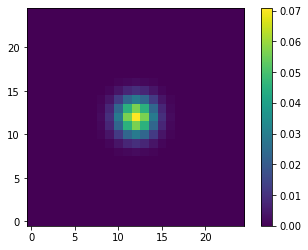

In [7]:
kernel_size = 25
nx, ny = (kernel_size, kernel_size) # kernel object shape
xg, yg = np.meshgrid(range(nx), range(ny))
xc, yc = (np.int(nx/2), np.int(ny/2))
sigma_k = 1.5 # gaussian kernel standard deviation
kernel = np.exp(-0.5 * ((xg - xc) ** 2 + (yg - yc) ** 2) / sigma_k ** 2)
kernel /= np.sum(kernel) # normalise to 1

# and plot
plt.imshow(kernel, origin='lower')
plt.colorbar();

# and convolve with the extended reference
R_ext = extend_image_hw(R, kernel_size)
data2_ext = convolve2d(R_ext, kernel, mode='same')

# and trim back to the correct size
hwidth = np.int((kernel_size - 1) / 2)
data2 = data2_ext[hwidth:data2_ext.shape[0]-hwidth, hwidth:data2_ext.shape[1]-hwidth]
save_numpy_as_fits(data2, 'data2.fits')

Great, now let's run PyTorchDIA and pyDANDIA (B08) on the 3 image pairs. We'll need to first need to setup the Cythonized B08 solution.

In [8]:
%load_ext Cython

In [9]:
%%cython

from __future__ import division
import numpy as np
cimport numpy as np
cimport cython
DTYPE = np.float64
ctypedef np.float64_t DTYPE_t

# compile suggestion: gcc -shared -pthread -fPIC -fwrapv -O2 -Wall -fno-strict-aliasing -I/somepath/include/python2.7 -o umatrix_routine.so umatrix_routine.c

@cython.boundscheck(False) # turn off bounds-checking
@cython.wraparound(False)  # turn off negative index wrapping
@cython.nonecheck(False)  # turn off negative index wrapping

def umatrix_construction(np.ndarray[DTYPE_t, ndim = 2] reference_image,np.ndarray[DTYPE_t, ndim = 2] weights, pandq, n_kernel_np, kernel_size_np):

    cdef int ni_image = np.shape(reference_image)[0]
    cdef int nj_image = np.shape(reference_image)[1]
    cdef double sum_acc = 0.
    cdef int idx_l,idx_m,idx_l_prime,idx_m_prime,idx_i,idx_j
    cdef int kernel_size = np.int(kernel_size_np)
    cdef int kernel_size_half = np.int(kernel_size_np)/2
    cdef int n_kernel = np.int(n_kernel_np)
    cdef np.ndarray u_matrix = np.zeros([n_kernel + 1, n_kernel + 1], dtype=DTYPE)

    for idx_p in range(n_kernel):
        for idx_q in range(idx_p,n_kernel):
            sum_acc = 0.
            idx_l, idx_m = pandq[idx_p]
            idx_l_prime, idx_m_prime = pandq[idx_q]
            for idx_i in range(kernel_size_half,ni_image-kernel_size+kernel_size_half+1):
                for idx_j in range(kernel_size_half,nj_image-kernel_size+kernel_size_half+1):
                    sum_acc += reference_image[idx_i + idx_l, idx_j + idx_m] * reference_image[idx_i + idx_l_prime,idx_j + idx_m_prime]  * weights[idx_i, idx_j]
            u_matrix[idx_p, idx_q] = sum_acc
            u_matrix[idx_q, idx_p] = sum_acc

    for idx_p in [n_kernel]:
        for idx_q in range(n_kernel):
            sum_acc = 0.
            idx_l = kernel_size
            idx_m = kernel_size
            idx_l_prime, idx_m_prime = pandq[idx_q]
            for idx_i in range(kernel_size_half,ni_image-kernel_size+kernel_size_half+1):
                for idx_j in range(kernel_size_half,nj_image-kernel_size+kernel_size_half+1):
                    sum_acc += reference_image[idx_i + idx_l_prime, idx_j + idx_m_prime] * weights[idx_i, idx_j]
            u_matrix[idx_p, idx_q] = sum_acc
    
    for idx_p in range(n_kernel):
        for idx_q in [n_kernel]:
            sum_acc = 0.
            idx_l, idx_m = pandq[idx_p]
            idx_l_prime = kernel_size
            idl_m_prime = kernel_size
            for idx_i in range(kernel_size_half,ni_image-kernel_size+kernel_size_half+1):
                for idx_j in range(kernel_size_half, nj_image-kernel_size+kernel_size_half+1):
                    sum_acc += reference_image[idx_i + idx_l, idx_j + idx_m] * weights[idx_i, idx_j] 
            u_matrix[idx_p, idx_q] = sum_acc

    sum_acc = 0.
    for idx_i in range(ni_image):
        for idx_j in range(nj_image):
            sum_acc += weights[idx_i, idx_j] 
    u_matrix[n_kernel, n_kernel] = sum_acc
    
    return u_matrix

def bvector_construction(np.ndarray[DTYPE_t, ndim = 2] reference_image,np.ndarray[DTYPE_t, ndim = 2] data_image,np.ndarray[DTYPE_t, ndim = 2] weights, pandq, n_kernel_np, kernel_size_np):

    cdef int ni_image = np.shape(data_image)[0]
    cdef int nj_image = np.shape(data_image)[1]
    cdef double sum_acc = 0.
    cdef int idx_l,idx_m,idx_l_prime,idx_m_prime,idx_i,idx_j
    cdef int kernel_size = np.int(kernel_size_np)
    cdef int kernel_size_half = np.int(kernel_size_np)/2
    cdef int n_kernel = np.int(n_kernel_np)
        
    cdef np.ndarray b_vector = np.zeros([n_kernel + 1], dtype=DTYPE)
    for idx_p in range(n_kernel):
        idx_l, idx_m = pandq[idx_p]
        sum_acc = 0.
        for idx_i in range(kernel_size_half,ni_image-kernel_size+kernel_size_half+1):
            for idx_j in range(kernel_size_half,nj_image-kernel_size+kernel_size_half+1):
                   sum_acc += data_image[idx_i, idx_j] * reference_image[idx_i + idx_l , idx_j + idx_m ] * weights[idx_i, idx_j]
        b_vector[idx_p] = sum_acc

    sum_acc = 0.
    for idx_i in range(ni_image):
        for idx_j in range(nj_image):
            sum_acc += data_image[idx_i, idx_j] * weights[idx_i, idx_j]
    b_vector[n_kernel] = sum_acc

    return b_vector

In [10]:
import PyTorchDIA_CCD
import torch
torch.backends.cudnn.deterministic = True # ensure PyTorchDIA solution is reproducible

PyTorch version: 1.6.0


In [11]:
## Importantly, we'll subtract the known (scalar) sky level from the reference frame.
## This breaks the degeneracy between the photometric scale factor and the 
## differential background.

R0 = np.copy(R) # for test '0'

print('Sky level:', sky)
R -= sky

# and reshape R for tests (i) and (iii)
R1, R3 = trim_image(R), trim_image(R)
R2 = np.copy(R)

Sky level: 734.6740023932911


The B08 algorithm shoud be able to return the exact kernel solution, to within machine precision, given that this approach is analytical. Let's define some functions to run the required operations for this algorithm.

In [12]:
# define function to return the model image, and appropriately guard-against edge effects
def model_image(R, kernel, B0):
    model = convolve2d(R, kernel, mode='same') + B0
    return model

def crop_model_image(ext_M, kernel_size):
    hwidth = np.int((kernel_size - 1) / 2)
    M = ext_M[hwidth:ext_M.shape[0]-hwidth, hwidth:ext_M.shape[1]-hwidth]
    return M

# function to build the kernel, U matrix and b vector
def construct_kernel_and_matrices(kernel_size, R, I, weights):

    pandq = []
    n_kernel = kernel_size * kernel_size
    ncount = 0
    half_kernel_size = int(int(kernel_size) / 2)
    for lidx in range(kernel_size):
        for midx in range(kernel_size):
            pandq.append((lidx - half_kernel_size, midx - half_kernel_size))


    R = R.astype('float64')
    I =  I.astype('float64')
    weights = weights.astype('float64')

    start_time = time.time()
    U = umatrix_construction(R, weights, pandq, n_kernel, kernel_size)
    b = bvector_construction(R, I, weights, pandq, n_kernel, kernel_size)
    print("--- Finished U and b construction in %s seconds ---" % (time.time() - start_time))
    return U, b


# define a function for the least-squares solution
def lstsq_solution(R, I, U, b, kernel_size):
    
    lstsq_result = np.linalg.lstsq(np.array(U), np.array(b), rcond=None)
    a_vector = lstsq_result[0]
    lstsq_fit = np.dot(np.array(U), a_vector)
    resid = np.array(b) - lstsq_fit
    reduced_chisqr = np.sum(resid ** 2) / (float(kernel_size * kernel_size))
    lstsq_cov = np.dot(np.array(U).T, np.array(U)) * reduced_chisqr
    resivar = np.var(resid, ddof=0) * float(len(a_vector))
    
    # use pinv in order to stabilize calculation
    a_var = np.diag(np.linalg.pinv(lstsq_cov) * resivar)

    a_vector_err = np.sqrt(a_var)
    output_kernel = np.zeros(kernel_size * kernel_size, dtype=float)
    if len(a_vector) > kernel_size * kernel_size:
        output_kernel = a_vector[:-1]
    else:
        output_kernel = a_vector
    output_kernel = output_kernel.reshape((kernel_size, kernel_size))

    err_kernel = np.zeros(kernel_size * kernel_size, dtype=float)
    if len(a_vector) > kernel_size * kernel_size:
        err_kernel = a_vector_err[:-1]
        err_kernel = err_kernel.reshape((kernel_size, kernel_size))
    else:
        err_kernel = a_vector_err
        err_kernel = err_kernel.reshape((kernel_size, kernel_size))

    output_kernel_2 = np.flip(np.flip(output_kernel, 0), 1)
    err_kernel_2 = np.flip(np.flip(err_kernel, 0), 1)
    bkg_kernel = a_vector[-1]
    output_kernel_2.shape

    return output_kernel_2, bkg_kernel

def B08(R, I, flat, ks, sigma_0, n_iters):
    
    for i in range(0, n_iters):

        if i == 0:

            # for first pass, estimate weights with inverse variance map
            w = 1./(I + sigma_0**2)
        else:
            # replace I with current estimate of the model, M
            w = 1./(M + sigma_0**2)

        if i < n_iters:

            print('\npyDANDIA solution, iter %d' % i)
            ext_R = extend_image_hw(R, ks)
            ext_I = extend_image_hw(I, ks)
            ext_w = extend_image_hw(w, ks)

            U, b = construct_kernel_and_matrices(ks, ext_R, ext_I, ext_w)
            kernel, B0 = lstsq_solution(ext_R, ext_I, U, b, ks)
            
            print('P, B0:', np.sum(kernel), B0)
            
            ext_M = model_image(ext_R, kernel, B0)
            M = crop_model_image(ext_M, ks)
           
    return kernel, B0, M     

In [13]:
## check all image pairs have the correct shapes
print(R1.shape, data1.shape)
print(R2.shape, data2.shape)
print(R3.shape, data3.shape)

(999, 999) (999, 999)
(1000, 1000) (1000, 1000)
(999, 999) (999, 999)


In [14]:
# ...and the precision of the input data
# important for ascertaining numerical rounding errors
# F32: 6-9 decimal digit precision
# F64: 15-17 decimal digit precision
print(R1.dtype, data1.dtype)
print(R2.dtype, data2.dtype)
print(R3.dtype, data3.dtype)

>f8 float64
>f8 float64
>f8 float64


Before moving on to tests (i)-(iii), let's do the test 0. Differencing R against itself. We should recover a kernel with a centre pixel of exactly 1 and zeros everywhere else.

In [15]:
kernel_b08_0, B0_b08_0, M_b08_0 = B08(R0 - sky, R0, np.ones(R0.shape), 19, 5, 3)


pyDANDIA solution, iter 0
--- Finished U and b construction in 113.22865867614746 seconds ---
P, B0: 1.0000000000000673 734.6740023932767

pyDANDIA solution, iter 1
--- Finished U and b construction in 110.63617730140686 seconds ---
P, B0: 0.9999999999999826 734.6740023932851

pyDANDIA solution, iter 2
--- Finished U and b construction in 109.75637197494507 seconds ---
P, B0: 1.0000000000000515 734.6740023932805


Photometric scale factor: 1.0000000000000515
Peak value of kernel: 0.9999999999999973
Differential Background: 734.6740023932805
Squared-sum of Difference image: 8.556559699265149e-15


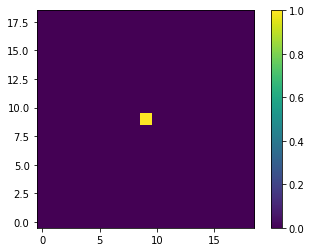

In [16]:
D_b08_0 = R0 - M_b08_0
plt.imshow(kernel_b08_0, origin='lower')
plt.colorbar();
print('Photometric scale factor:', np.sum(kernel_b08_0))
print('Peak value of kernel:', np.max(kernel_b08_0))
print('Differential Background:', B0_b08_0)
print('Squared-sum of Difference image:', np.sum(D_b08_0**2))

--- Time to move data onto GPU: 2.1294498443603516 ---
Check dtype of data and weights:
torch.float32 torch.float32 torch.float32 torch.float32
Check size of data and weights:
torch.Size([1, 1, 1000, 1000]) torch.Size([1, 1, 1000, 1000]) torch.Size([1, 1, 19, 19]) torch.Size([1])
Starting optimisation
Switching to Quasi-Newton step after 2147 SD steps
Converged!
Total steps taken: 2150
SD steps: 2147
L-BFGS steps: 3
--- Finished kernel and background fit in 152.66448974609375 seconds ---
Photometric scaling: tensor(1.0004431009, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 734.1301879882812


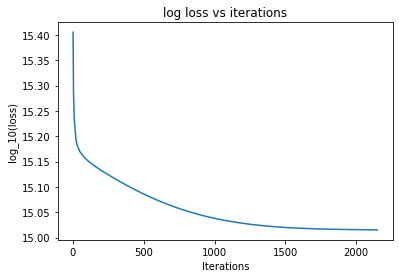

--- Finished in a total of 155.01643753051758 seconds ---


In [17]:
# and now for PyTorchDIA
kernel_pt_0, B0_pt_0 = PyTorchDIA_CCD.DIA(R0 - sky,
                           R0,
                           np.ones(R0.shape), # flatfield
                           rdnoise = 5,
                           G = 1,
                           ks = 19,
                           lr_kernel = 1e-3,
                           lr_B = 1,
                           max_iterations = 25000,
                           poly_degree=0,
                           alpha = 0.,
                           Newton_tol = 1e-6,
                           tol = 1e-9,
                           fast=True,
                           fisher=False,
                           show_convergence_plots=True)

ext_R0 = extend_image_hw(R0 - sky, kernel_size=19)
ext_M_pt_0 = model_image(ext_R0, kernel_pt_0, B0_pt_0)
M_pt_0 = crop_model_image(ext_M_pt_0, kernel_size=19)

Photometric scale factor: 1.000443
Peak value of kernel: 0.9992727
Differential Background: 734.1301879882812
Squared-sum of Difference image: 296163.37582426355


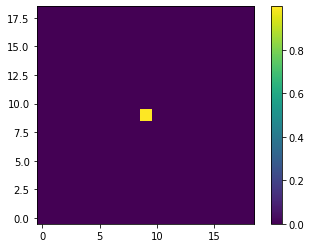

In [18]:
D_pt_0 = R0 - M_pt_0
plt.imshow(kernel_pt_0, origin='lower')
plt.colorbar();
print('Photometric scale factor:', np.sum(kernel_pt_0))
print('Peak value of kernel:', np.max(kernel_pt_0))
print('Differential Background:', B0_pt_0)
print('Squared-sum of Difference image:', np.sum(D_pt_0**2))

**Test '0' discussion**

As expected, the B08 algorithm does an excellent job and returns the correct kernel to within numerical rounding errors. Unfortunately, the picture is less clean for PyTorchDIA. Ideally, we would hope the precision would be at the convergence tolerance of the data precision. PyTorchDIA uses F32 by default, giving 6-9 decimal digits of precision, yet the peak kernel pixel is only accurate to 4 digits. But does this 'algorithmic' systematic source of uncertainty matter in practice?

The large difference in the squared-sum of the difference image between the two approaches is refletive of the underestimation of the sky level in the target image by ~0.54 ADU. This systematic non-zero offset in the difference image is in fact trivial to correct for if measuring difference fluxes by PSF fitting photometry; one just has to include an additional background paramter in the fit. In this example, as far as photometroc accuracy is concerned, the most important 'parameter' is the photometric scale factor, $P$. We see that PyTorchDIA has slightly overestimated $P$, with a fractional systematic uncertainty of ~0.04 %. Fortunately, this is however below typical photometric precision -- which is usually in the range of 0.1 - 5 % -- and so would only pose a problem where the stochastic noise component of the photometry is at ~0.01 % or better.

In [19]:
# OK, let's run B08 on the image pair for test (i)
kernel_b08_1, B0_b08_1, M_b08_1 = B08(R1, data1, np.ones(data1.shape), 19, 5, 3)


pyDANDIA solution, iter 0
--- Finished U and b construction in 107.99472212791443 seconds ---
P, B0: 1.0000258455182671 734.6700471761013

pyDANDIA solution, iter 1
--- Finished U and b construction in 107.16765570640564 seconds ---
P, B0: 1.0000110511704072 734.6722087506098

pyDANDIA solution, iter 2
--- Finished U and b construction in 106.27797317504883 seconds ---
P, B0: 1.000011050962014 734.6722087515623


Photometric scale factor: 1.000011050962014
Peak value of kernel: 1.000006935064921
Differential Background: 734.6722087515623
Squared-sum of Difference image: 1574649.3348808924


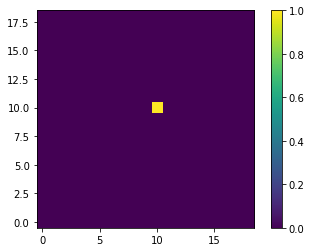

In [20]:
D_b08_1 = data1 - M_b08_1
plt.imshow(kernel_b08_1, origin='lower')
plt.colorbar();
print('Photometric scale factor:', np.sum(kernel_b08_1))
print('Peak value of kernel:', np.max(kernel_b08_1))
print('Differential Background:', B0_b08_1)
print('Squared-sum of Difference image:', np.sum(D_b08_1**2))

--- Time to move data onto GPU: 0.004529237747192383 ---
Check dtype of data and weights:
torch.float32 torch.float32 torch.float32 torch.float32
Check size of data and weights:
torch.Size([1, 1, 999, 999]) torch.Size([1, 1, 999, 999]) torch.Size([1, 1, 19, 19]) torch.Size([1])
Starting optimisation
Switching to Quasi-Newton step after 2216 SD steps
Converged!
Total steps taken: 2219
SD steps: 2216
L-BFGS steps: 3
--- Finished kernel and background fit in 157.9612250328064 seconds ---
Photometric scaling: tensor(1.0002648830, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 734.1428833007812


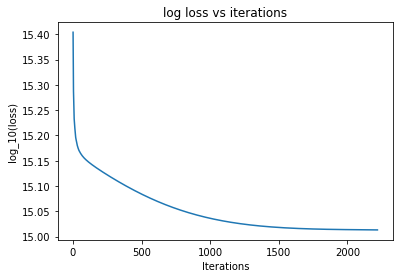

--- Finished in a total of 158.14565920829773 seconds ---


In [21]:
# and now for PyTorchDIA
kernel_pt_1, B0_pt_1 = PyTorchDIA_CCD.DIA(R1,
                           data1,
                           np.ones(data1.shape), # flatfield
                           rdnoise = 5,
                           G = 1,
                           ks = 19,
                           lr_kernel = 1e-3,
                           lr_B = 1,
                           max_iterations = 25000,
                           poly_degree=0,
                           alpha = 0.,
                           Newton_tol = 1e-6,
                           tol = 1e-9,
                           fast=True,
                           fisher=False,
                           show_convergence_plots=True)

ext_R1 = extend_image_hw(R1, kernel_size=19)
ext_M_pt_1 = model_image(ext_R1, kernel_pt_1, B0_pt_1)
M_pt_1 = crop_model_image(ext_M_pt_1, kernel_size=19)

Photometric scale factor: 1.0002648
Peak value of kernel: 0.99954355
Differential Background: 734.1428833007812
Squared-sum of Difference image: 1855310.3012801006


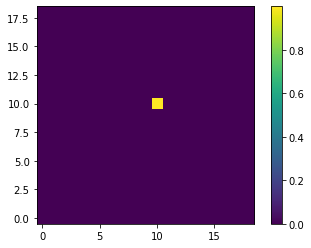

In [23]:
D_pt_1 = data1 - M_pt_1
plt.imshow(kernel_pt_1, origin='lower')
plt.colorbar();
print('Photometric scale factor:', np.sum(kernel_pt_1))
print('Peak value of kernel:', np.max(kernel_pt_1))
print('Differential Background:', B0_pt_1)
print('Squared-sum of Difference image:', np.sum(D_pt_1**2))

**Test (i) discussion**

Both tests do fairly well here, but B08 again wins (unsurprisingly!). Its the underestimation of the background term by PyTorchDIA that really separates them. Both approaches overestimate $P$, and B08 does better by an order of magnitude, although happily, this fractional uncertainty is still typical stochastic photometric noise for both approaches.

In [25]:
# OK, let's run B08 on test (ii)
kernel_b08_2, B0_b08_2, M_b08_2 = B08(R2, data2, np.ones(data2.shape), 19, 5, 3)


pyDANDIA solution, iter 0
--- Finished U and b construction in 115.26693391799927 seconds ---
P, B0: 1.0187250611122793 732.2239384113913

pyDANDIA solution, iter 1
--- Finished U and b construction in 114.69007134437561 seconds ---
P, B0: 1.0134648749575224 732.9217982935597

pyDANDIA solution, iter 2
--- Finished U and b construction in 117.9832091331482 seconds ---
P, B0: 1.0134244278146516 732.9219827236435


Photometric scale factor: 1.0134244278146516
Peak value of kernel: 0.07111548019933431
Differential Background: 732.9219827236435
Squared-sum of Difference image: 344449182.6942327


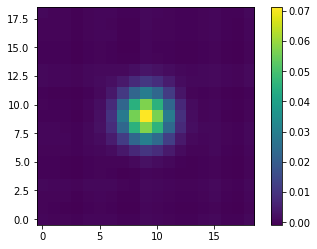

In [26]:
D_b08_2 = data2 - M_b08_2
plt.imshow(kernel_b08_2, origin='lower')
plt.colorbar();
print('Photometric scale factor:', np.sum(kernel_b08_2))
print('Peak value of kernel:', np.max(kernel_b08_2))
print('Differential Background:', B0_b08_2)
print('Squared-sum of Difference image:', np.sum(D_b08_2**2))

--- Time to move data onto GPU: 0.007410764694213867 ---
Check dtype of data and weights:
torch.float32 torch.float32 torch.float32 torch.float32
Check size of data and weights:
torch.Size([1, 1, 1000, 1000]) torch.Size([1, 1, 1000, 1000]) torch.Size([1, 1, 19, 19]) torch.Size([1])
Starting optimisation
Switching to Quasi-Newton step after 454 SD steps
Converged!
Total steps taken: 457
SD steps: 454
L-BFGS steps: 3
--- Finished kernel and background fit in 35.919472455978394 seconds ---
Photometric scaling: tensor(1.0116515160, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 732.6577758789062


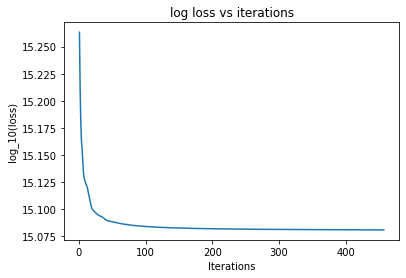

--- Finished in a total of 36.18128991127014 seconds ---


In [29]:
# test (ii)
kernel_pt_2, B0_pt_2 = PyTorchDIA_CCD.DIA(R2,
                           data2,
                           np.ones(data2.shape), # flatfield
                           rdnoise = 5,
                           G = 1,
                           ks = 19,
                           lr_kernel = 1e-3,
                           lr_B = 10,
                           max_iterations = 25000,
                           poly_degree=0,
                           alpha = 0.,
                           Newton_tol = 1e-6,
                           tol = 1e-9,
                           fast=True,
                           fisher=False,
                           show_convergence_plots=True)

ext_R2 = extend_image_hw(R2, kernel_size=19)
ext_M_pt_2 = model_image(ext_R2, kernel_pt_2, B0_pt_2)
M_pt_2 = crop_model_image(ext_M_pt_2, kernel_size=19)

Photometric scale factor: 1.0116515
Peak value of kernel: 0.07092436
Differential Background: 732.6577758789062
Squared-sum of Difference image: 344468165.7696521


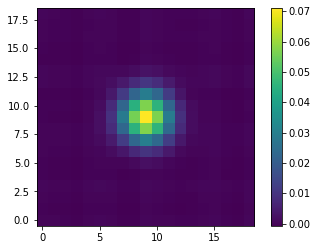

In [30]:
D_pt_2 = data2 - M_pt_2
plt.imshow(kernel_pt_2, origin='lower')
plt.colorbar();
print('Photometric scale factor:', np.sum(kernel_pt_2))
print('Peak value of kernel:', np.max(kernel_pt_2))
print('Differential Background:', B0_pt_2)
print('Squared-sum of Difference image:', np.sum(D_pt_2**2))

**Test (ii) discussion**

Both approaches did badly here - why!!

Thank goodness I'm no longer generating the synthetic target images by convolving the reference! Not only does this propagate sampling errors, but bad things happen at the image borders. **Repeat this but crop by a half-width of the kernel which convolved the reference image**.

In [31]:
# OK, let's run B08 on test (iii)
kernel_b08_3, B0_b08_3, M_b08_3 = B08(R3, data3, np.ones(data3.shape), 19, 5, 3)


pyDANDIA solution, iter 0
--- Finished U and b construction in 115.64415669441223 seconds ---
P, B0: 0.9999961602824203 734.6726156491444

pyDANDIA solution, iter 1
--- Finished U and b construction in 116.3253059387207 seconds ---
P, B0: 0.9999916166331503 734.6732849312222

pyDANDIA solution, iter 2
--- Finished U and b construction in 116.07786822319031 seconds ---
P, B0: 0.9999916166144369 734.6732849313273


Photometric scale factor: 0.9999916166144369
Peak value of kernel: 0.36049184388588135
Differential Background: 734.6732849313273
Squared-sum of Difference image: 490586.257668384


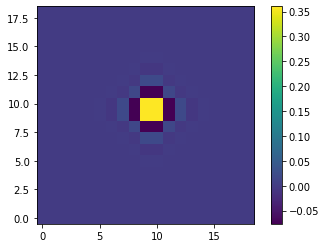

In [32]:
D_b08_3 = data3 - M_b08_3
plt.imshow(kernel_b08_3, origin='lower')
plt.colorbar();
print('Photometric scale factor:', np.sum(kernel_b08_3))
print('Peak value of kernel:', np.max(kernel_b08_3))
print('Differential Background:', B0_b08_3)
print('Squared-sum of Difference image:', np.sum(D_b08_3**2))

--- Time to move data onto GPU: 0.015465259552001953 ---
Check dtype of data and weights:
torch.float32 torch.float32 torch.float32 torch.float32
Check size of data and weights:
torch.Size([1, 1, 999, 999]) torch.Size([1, 1, 999, 999]) torch.Size([1, 1, 19, 19]) torch.Size([1])
Starting optimisation
Switching to Quasi-Newton step after 1350 SD steps
Converged!
Total steps taken: 1354
SD steps: 1350
L-BFGS steps: 4
--- Finished kernel and background fit in 98.44115543365479 seconds ---
Photometric scaling: tensor(0.9993044138, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 734.2620239257812


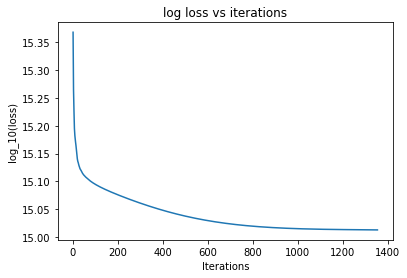

--- Finished in a total of 98.6885621547699 seconds ---


In [34]:
# test (iii)
kernel_pt_3, B0_pt_3 = PyTorchDIA_CCD.DIA(R3,
                           data3,
                           np.ones(data3.shape), # flatfield
                           rdnoise = 5,
                           G = 1,
                           ks = 19,
                           lr_kernel = 1e-3,
                           lr_B = 10,
                           max_iterations = 25000,
                           poly_degree=0,
                           alpha = 0.,
                           Newton_tol = 1e-6,
                           tol = 1e-9,
                           fast=True,
                           fisher=False,
                           show_convergence_plots=True)

ext_R3 = extend_image_hw(R3, kernel_size=19)
ext_M_pt_3 = model_image(ext_R3, kernel_pt_3, B0_pt_3)
M_pt_3 = crop_model_image(ext_M_pt_3, kernel_size=19)

Photometric scale factor: 0.9993043
Peak value of kernel: 0.360637
Differential Background: 734.2620239257812
Squared-sum of Difference image: 663496.8534707826


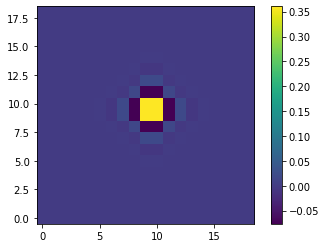

In [35]:
D_pt_3 = data3 - M_pt_3
plt.imshow(kernel_pt_3, origin='lower')
plt.colorbar();
print('Photometric scale factor:', np.sum(kernel_pt_3))
print('Peak value of kernel:', np.max(kernel_pt_3))
print('Differential Background:', B0_pt_3)
print('Squared-sum of Difference image:', np.sum(D_pt_3**2))

**Test (iii) discussion**

Both approaches do OK here, with B08 again being superior. Once again, the fractional uncertainty in $P$ as measured by PyTorchDIA is just below the best end of the range of stochastic noise levels in typical photometry